# Loading data and initial plotting

This notebook was used to write up some data loading functions and to play with plotting with altair. 

**Data source**

https://data.broadinstitute.org/chembank/assay/index.html

`AntibacterialAssay (1106)`, Sarah Stanley

Click file `FluorProtein(1106.0023)` to download

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from helpers import *


In [2]:
data_raw = pd.read_csv("data/antibiotics/assay.1106.0023.tsv", sep="\t")


In [3]:
if False in data_raw.all().unique():
    print("0 values are present")
else:
    print(
        "No 0 values present"
    )  # will return False if 0 is present in one of the columns

if data_raw.isnull().values.any():
    print("Null values are present")
else:
    print("Null values are not present")

print(f"There are {data_raw.duplicated().sum()} duplicated rows")


0 values are present
Null values are present
There are 0 duplicated rows


In [4]:
data_raw.head()


,ASSAY_ID,ASSAY,PROJECT,PLATE,WELL,WELL_TYPE,RAW_VALUE_A,BSUB_VALUE_A,Z_SCORE_A,RAW_VALUE_B,BSUB_VALUE_B,Z_SCORE_B,COMPOSITE_Z,REPRODUCIBILITY,CHEMBANK_ID,VIRTUAL_ID,SMILES
0,1106.0023,FluorProtein(1106.0023),AntibacterialAssay,1106.0023.2001,A01,compound treatment,41.959,-7.93,-1.44,63.037,6.240,1.12,-0.2295,-0.1259,1205993.0,ChemDiv3_000001,Cc1cc(c(O)c(c1)C(C)(C)C)n2nc3ccc(Cl)cc3n2
1,1106.0023,FluorProtein(1106.0023),AntibacterialAssay,1106.0023.2001,A02,compound treatment,46.695,-3.19,-0.58,59.127,2.330,0.42,-0.1157,-0.1620,1044707.0,ChemDiv3_000002,OC(=O)c1ccccc1C(=O)c2ccc(cc2)c3ccccc3
2,1106.0023,FluorProtein(1106.0023),AntibacterialAssay,1106.0023.2001,A03,compound treatment,46.684,-3.20,-0.58,70.293,13.500,2.41,1.2958,0.5217,1699093.0,ChemDiv3_000003,Cc1ccc(Nc2ccc3ncnc4-c5ccccc5C(=O)c2c43)cc1
3,1106.0023,FluorProtein(1106.0023),AntibacterialAssay,1106.0023.2001,A04,compound treatment,49.007,-0.88,-0.16,58.374,1.570,0.28,0.0861,0.2659,3117569.0,ChemDiv3_000004,Clc1c(sc2ccccc12)C(=O)Nc3ccc(Cl)cc3
4,1106.0023,FluorProtein(1106.0023),AntibacterialAssay,1106.0023.2001,A05,compound treatment,44.434,-5.45,-0.99,56.533,-0.267,-0.05,-0.7344,-0.7403,1561677.0,ChemDiv3_000005,CCOC(=O)c1c(O)nc2c3ccccc3oc2c1c4ccccc4


In [5]:
print(f"{data_raw.PLATE.nunique()} plates")

print(f"{data_raw.SMILES.nunique()} compounds")


27 plates
7560 compounds


In [6]:
data.WELL_TYPE.unique()


NameError: name 'data' is not defined

In [ ]:
summary_stats(
    data,
    "PLATE",
)


In [ ]:
data_raw.RAW_VALUE_A.describe().round(2)


IQR is ~43-52 units, but there is at least one value in the thousands of units. 

In [ ]:
high_fluor = data_raw.loc[data_raw["RAW_VALUE_A"] > 100]
high_fluor


In [ ]:
print(f"{high_fluor.shape[0]} rows")


In [ ]:
print(f"{high_fluor.SMILES.nunique()} unique compounds")


These might be outliers, perhaps because the compounds are autofluorescent. Exclude these observations with > 200 units for now. 

In [7]:
data = data_raw.loc[data_raw["RAW_VALUE_A"] <= 200]

print(f"{(data_raw.shape[0]-data.shape[0])} rows excluded")


4 rows excluded


Distribution of response:

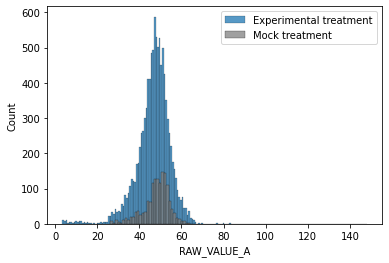

In [8]:
sns.histplot(data["RAW_VALUE_A"])
sns.histplot(
    data.query('WELL_TYPE == "mock treatment"')["RAW_VALUE_A"],
    color="grey",
    label="mock",
)
plt.legend(
    labels=["Experimental treatment", "Mock treatment"],
)


Subselect data to plot to avoid overplotting

In [9]:
import random
from random import sample

random.seed(20220221)
plates = list(data.PLATE.unique())

plate_sample = sample(plates, 4)

data_sample = data.loc[data["PLATE"].isin(plate_sample)]


In [10]:
chart1 = (
    alt.Chart(data_sample)
    .mark_point(size=80)
    .encode(
        x="PLATE",
        y="RAW_VALUE_A",
        tooltip=["SMILES", "RAW_VALUE_A"],
    )
    .interactive()
    .properties(title="Response grouped by plate", width=800, height=300)
)

chart2 = (
    alt.Chart(data_sample.query('WELL_TYPE == "mock treatment"'))
    .mark_point(size=80)
    .encode(
        x="PLATE",
        y="RAW_VALUE_A",
        tooltip=["SMILES", "RAW_VALUE_A"],
        color=alt.value("grey"),
        shape=alt.Shape(
            "WELL_TYPE",
            title="Mock",
            scale=alt.Scale(
                domain=[
                    "mock treatment",
                ],
                range=[
                    "triangle",
                ],
            ),
        ),
    )
    .interactive()
    .properties(title="Response grouped by plate", width=800, height=300)
)


chart1 + chart2


alt.LayerChart(...)

In [11]:
MEDIAN_RESPONSE = (
    data_sample[["SMILES", "RAW_VALUE_A"]]
    .groupby("SMILES")
    .mean()
    .rename(columns={"RAW_VALUE_A": "RAW_VALUE_A_med"})
    .reset_index()
    .sort_values(by="RAW_VALUE_A_med")
)
compounds_ordered_by_median = list(MEDIAN_RESPONSE.SMILES)

chart = (
    alt.Chart(data_sample)
    .mark_point(size=50)
    .encode(
        x=alt.X(
            "SMILES", sort=compounds_ordered_by_median, axis=alt.Axis(labels=False)
        ),
        y=alt.Y("RAW_VALUE_A"),
        color="SMILES",
    )
    .interactive()
    .properties(width=800, height=300, title="Response for each compound")
)
chart.encoding.x.title = "Compound"
chart


alt.Chart(...)